<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [17]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

     |████████████████████████████████| 40 kB 3.8 MB/s 
     |████████████████████████████████| 161 kB 8.1 MB/s 
  Created wheel for openai: filename=openai-0.15.0-py3-none-any.whl size=50093 sha256=f050885756883c4cae435a8e9425f00f7a7382bd2f678b8179b0ea40b1060153
  Stored in directory: /root/.cache/pip/wheels/bd/b1/b5/01a94056fd87ef0ed913b2fa6f1161076b730cf1449f579ab7
Successfully built openai


## imports

In [38]:
import numpy
import pandas 

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

# supply openai api key via file 
openai.api_key = open('openai_key').read()


In [62]:
# configurations
config_dict = { 'analysis_start_year'  : 2021
              , 'analysis_start_month' : 1
              , 'analysis_end_year'    : 2021
              , 'analysis_end_month'   : 2
              , 'analysis_country'     : 'US' }


# topics
topics_explicit = ['flipflops', 'pumpkin', 'turkey', 'baseball', 'basketball', 'football', 'kite', 'ice cream', 'hotdog', 'rocket', 'fireworks', 'pizza', 'bbq', 'parade']



In [63]:
df_total = pandas.DataFrame()

for topic in topics_explicit:


  pytrend = TrendReq()
  pytrend.build_payload(kw_list=[topic], timeframe='today 5-y')
  df = pytrend.interest_over_time()


  df_total[topic] = df[topic]

# drop nans
df_total = df_total.dropna()

In [65]:
# capture features
df_features = df_total[topics_explicit]

In [66]:
# normalize
df_features=(df_features-df_features.mean())/df_features.std()

In [67]:

# normalize it all history (meanly)
df_total = (df_total-df_total.mean())/df_total.std()
df_features_recent = df_total[df_total.index > '1/1/2010']

# normalize it recent history (meanly)
df_features_recent = (df_features_recent-df_features_recent.mean())/df_features_recent.std()

# group by week, average occurences
df_agg = df_features
df_agg_recent = df_features_recent


In [68]:
# populate us
df_stk=pandas.DataFrame()
globalst=[]

# navigate hierarchy, each combination of WEEKNUM and FLOWER
for col in df_agg:           # flower
    for val in df_agg.index.weekofyear: # weeknum
        
        
        # time sensitive
        fs_val = df_agg[col][val]                   # full spectrum
        
        # in cases of no recent
        try:
            fs_val_recent = df_agg_recent[col][val] # recent spectrum
        except:
            fs_val_recent = 0
        
        
        # at this combo of flower/weeknum, check which source is greater, as its our limiter
        if fs_val > fs_val_recent:
            fs_max = fs_val
            fs_min = fs_val_recent
            fs_max_src = 'full'
        else:
            fs_max = fs_val_recent
            fs_min = fs_val
            fs_max_src = 'recent'
        
        
        # if max frequency signal greater than 0
        #if fs_max > 0 or fs_min > 0:
        #if fs_max > 0:
        if fs_max > 0.1 and fs_min > 0.1:
            
            # secondary source counter
            sec_i=1
            
            
            # iterate through each instance of max bin occurence, determining number of weeks written
            for x in range(0,int(abs(fs_max) * 100)):
            
            
                # full source
                if fs_max_src == 'full':
                    
                    if sec_i < int(abs(fs_min) * 100):
                    
                        lst=[val, val, col]
                        globalst.append(lst)
                    
                    else:
                        
                        lst=[val, None, col]
                        globalst.append(lst)                    
                    
                # recent source
                if sec_i < int(abs(fs_min) * 100):
                    
                    lst=[val, val, col]
                    globalst.append(lst)
                    
                else:
                        
                    lst=[None, val, col]
                    globalst.append(lst)                     
                    
                    
                sec_i+=1
                #print(sec_i)
                #print(df_agg[col][val])
                #print(df_agg_recent[col][val])
                
                
                #lst=[val, col]
                globalst.append(lst)
       
    
        #df_stk=df_stk.append(lst)

df_flat = pandas.DataFrame(globalst
                      ,columns=['WeekNum'
                               ,'WeekNum_Rct'
                               ,'Flower_Tot'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [69]:
df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()
df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]
print(df_stats.columns)
df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

#df_stats['Name'] = '00' + str((df_stats['WeekNum mean']).astype(int)) #+ df_stats['Flower']
df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

i = 1
for index, row in df_stats.iterrows():
    #print(row['Flower'], row['Name'])
    df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower'] = df_flat['Flower'].replace(row['Flower'], str(i) + row['Flower'])
    i+=1

print(df_flat)

Index(['Flower_Tot', 'WeekNum mean', 'WeekNum count', 'WeekNum_Rct mean',
       'WeekNum_Rct count'],
      dtype='object')
        WeekNum  WeekNum_Rct      Flower_Tot
0          10.0         10.0  2350 flipflops
1          10.0         10.0  2350 flipflops
2          10.0         10.0  2350 flipflops
3          10.0         10.0  2350 flipflops
4          10.0         10.0  2350 flipflops
...         ...          ...             ...
288449     52.0         52.0     4331 parade
288450     52.0         52.0     4331 parade
288451     52.0         52.0     4331 parade
288452      NaN         52.0     4331 parade
288453      NaN         52.0     4331 parade

[288454 rows x 3 columns]


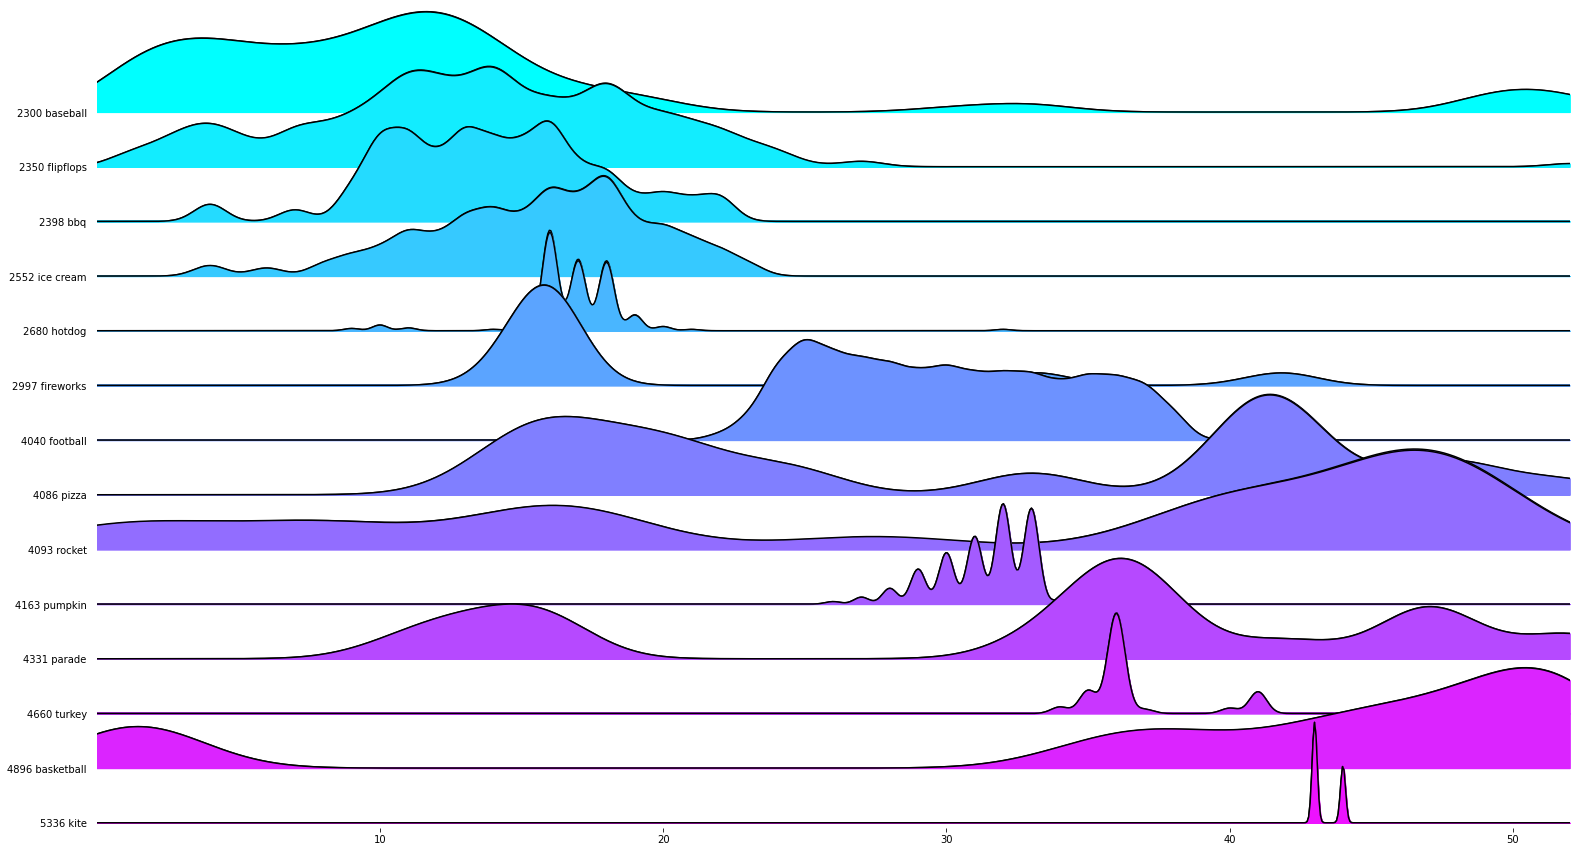

In [70]:
fig, axes = joypy.joyplot(df_flat
                          , column=['WeekNum', 'WeekNum_Rct']
                          , by='Flower_Tot'
                          , overlap=1.2
                          , fill=True
                          , figsize=(22,12)
                          , x_range = [0,52]
                          , colormap=cm.cool                         
                          , ylim='own'
                         )

plt.savefig('frank_jj.png')
plt.show()

In [ ]:

c = df_agg.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")



#df_slice = so[50:-13].to_frame()
#df_slice = so[:-13].to_frame()

df_slice = so[70:-len(topics_explicit)].to_frame()
df_slice.hist()

In [72]:
df_slice

,,0
fireworks,basketball,0.159222
basketball,fireworks,0.159222
hotdog,turkey,0.167941
turkey,hotdog,0.167941
hotdog,pizza,0.185378
...,...,...
bbq,flipflops,0.676891
ice cream,flipflops,0.762640
flipflops,ice cream,0.762640
bbq,ice cream,0.894653


In [ ]:
seaborn.pairplot(df_agg,diag_kind = 'kde',kind = 'scatter',palette = 'husl')

In [ ]:
df_slice.reset_index(inplace=True)

In [ ]:
df_slice.columns = ['source','target','weight']

In [ ]:
df_slice['cost'] = numpy.random.randint(1, 6, df_slice.shape[0])

In [ ]:
from networkx.algorithms.bipartite.basic import color
from networkx import *
import networkx as nx
import sys

n=10 # 10 nodes
m=20 # 20 edges

#G=gnm_random_graph(n,m)
#G=nx.from_pandas_dataframe(df_slice, 0, 'b', ['weight', 'cost'])
#G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight', 'cost'])
G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight'])


# some properties
print("node degree clustering")
for v in nodes(G):
    print(v,degree(G,v),clustering(G,v))

# print the adjacency list to terminal 
write_adjlist(G,sys.stdout)

plt.figure(3,figsize=(12,12)) 
draw(G
     ,with_labels=True
     ,edge_color='gray'
     ,node_color='white'
     ,font_size=22)


In [ ]:
#df_slice.columns(["l","weight", "cost"])
G["football"]["baseball"]["weight"]


In [ ]:
# list nodes
G.nodes.items()

# edges
G.number_of_edges()

# print neighbors
for v in G.neighbors('rocket'):
  print(v)

In [ ]:
# send openai question, receive response
def get_response(question):
  response = openai.Completion.create(
    engine="text-davinci-001",
    prompt=question,
    temperature=.01,
    max_tokens=250,
    top_p=1,
    frequency_penalty=50,
    presence_penalty=0
  )

  # process response
  response_choices = response["choices"]
  response_choice_text = response_choices[0]["text"]
  ''.join(e for e in response_choice_text if e.isalnum())
  response = response_choices[0]["text"].strip('\n')

  return response

In [ ]:
responses = []


# retrieve 
retrieval = get_response('List similiar seasonal occurying concepts to baseball besides basketball and football and hockey and soccer')
responses.append(retrieval)

In [ ]:
responses